In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 19 11:26:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!ls -al drive/My\ Drive/Facebook_bAbI

total 1289371
-rw------- 1 root root     233939 May 19 11:26 Bert.ipynb
-rw------- 1 root root 1314604232 May 18 20:38 best_bert_base_task5-2_12_classW.hdf5
-rw------- 1 root root      31743 May 19 11:15 ChatBot.ipynb
-rw------- 1 root root    2723622 May 18 20:19 task5_dev_trn.csv
-rw------- 1 root root    1352677 May 18 20:19 task5_tst.csv
-rw------- 1 root root    1368267 May 18 20:19 task5_tst_OOV.csv


In [6]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 May 19 11:27 .
drwxr-xr-x 1 root root 4096 May 19 10:58 ..
drwxr-xr-x 1 root root 4096 May 13 16:29 .config
drwx------ 4 root root 4096 May 19 11:27 drive
drwxr-xr-x 1 root root 4096 May 13 16:29 sample_data


In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/working'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub
import keras.backend as kb
from sklearn.utils import class_weight
import keras

Using TensorFlow backend.


In [8]:
!rm tokenization.py*
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
import tokenization

rm: cannot remove 'tokenization.py*': No such file or directory
     |████████████████████████████████| 1.1MB 4.9MB/s 


In [0]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [0]:
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
task5_train = pd.read_csv("drive/My Drive/Facebook_bAbI/task5_dev_trn.csv")
task5_test = pd.read_csv("drive/My Drive/Facebook_bAbI/task5_tst.csv")
task5_test_OOV = pd.read_csv("drive/My Drive/Facebook_bAbI/task5_tst_OOV.csv")

In [0]:


answers = {'where should it be': 0 ,
           'how many people would be in your party':   1,
           'which price range are looking for' :   2 ,
           'api_call' :  3 ,
           'sure is there anything else to update' : 4 ,
           'sure let me find an other option for you' :   5 ,
           'great let me do the reservation' :   6 ,
           'phone_call' :  7 ,
           'is there anything i can help you with' :  8 ,
           "you're welcome" : 9 ,
           'any preference on a type of cuisine' : 10 ,
           '_address' : 11 }

def bert_encode_output_type_sparse(texts):   
  all_outputs = []
  for output in texts:
    all_outputs.append(answers[output])  
  return all_outputs

def bert_encode_output_type(texts, nr_classes=10):
  all_outputs = []
  for output in texts:
    result = [0]*nr_classes
    result[answers[output]] = 1
    all_outputs.append(result)
  return np.array(all_outputs)

In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_ids = []
    all_masks = []
    all_segments = []
    maximum_len = 0

    for sentences in texts:
      input_sequence = ["[CLS]"]

      question = True
      for sentence in sentences.split("#")[:-1]:
        if question == True:
          pad = 0
          question = False
        else:
          pad = 1
          question = True
     
        tokens = tokenizer.tokenize(sentence)
        input_sequence += tokens 
        input_sequence += ["[SEP]"]
      
      input_sequence = input_sequence[:max_len]
       
      pad_len = max_len - len(input_sequence)
      
      ids = tokenizer.convert_tokens_to_ids(input_sequence)
      maximum_len = max(maximum_len, len(ids))
      ids += [0]*pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0]*max_len

      if len(ids) != max_len or len(pad_masks) != max_len or len(segment_ids) != max_len:
        print("len(ids)", len(ids))
        print("len(pad_masks)", len(pad_masks))
        print("len(segment_ids)", len(segment_ids))
        print()

      all_ids.append(ids)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)

      
    print("maximum_len", maximum_len)
    return np.array(all_ids), np.array(all_masks), np.array(all_segments)


In [18]:
task5_train_input = bert_encode(task5_train["input"], tokenizer, max_len=100)
task5_test_input = bert_encode(task5_test["input"], tokenizer, max_len=100)
task5_test_OOV_input = bert_encode(task5_test_OOV["input"], tokenizer, max_len=100)


maximum_len 54
maximum_len 53
maximum_len 53


In [19]:
print(len(task5_train_input[0]))

34904


In [0]:
task5_train_labels = bert_encode_output_type(task5_train["output"], nr_classes=12)
task5_test_labels = bert_encode_output_type(task5_test["output"], nr_classes=12)
task5_test_OOV_labels = bert_encode_output_type(task5_test_OOV["output"], nr_classes=12)

In [0]:
train_input = task5_train_input
test_input = task5_test_input
test_OOV_input = task5_test_OOV_input

train_labels = task5_train_labels
test_labels = task5_test_labels
test_OOV_labels = task5_test_OOV_labels

In [24]:
encoded_inputs = train_input
print(len(encoded_inputs))
print(len(encoded_inputs[0]))
print(encoded_inputs[0][0])
print(encoded_inputs[1][0])
print(encoded_inputs[2][0])


3
34904
[ 101 1045 1005 1040 2066 2000 2338 1037 2795 2007 3059 2833  102    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:

def build_model(bert_layer, max_len=512, max_out_len=16):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dropout(0.2) (clf_output)
    out = Dense(max_out_len, activation='softmax')(out)
    
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss=tf.keras.losses.categorical_crossentropy, metrics=["categorical_accuracy"])
    
    return model




In [26]:
model = build_model(bert_layer, max_len=100 , max_out_len = 12)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [27]:
task5_labels_sparse = bert_encode_output_type_sparse(task5_train["output"])
print(task5_labels_sparse)

[0, 1, 2, 3, 4, 4, 4, 3, 5, 5, 6, 7, 8, 9, 10, 3, 4, 4, 4, 3, 5, 5, 6, 7, 8, 9, 0, 3, 4, 4, 4, 3, 5, 5, 6, 11, 8, 9, 10, 3, 4, 3, 6, 7, 8, 9, 1, 3, 4, 4, 4, 3, 5, 5, 5, 6, 7, 11, 8, 9, 10, 0, 3, 4, 4, 3, 5, 5, 6, 7, 8, 9, 10, 0, 3, 4, 4, 4, 3, 5, 5, 6, 7, 8, 9, 1, 3, 4, 4, 4, 3, 5, 5, 6, 11, 8, 9, 10, 0, 2, 3, 4, 4, 3, 5, 5, 5, 6, 11, 7, 8, 9, 1, 3, 4, 4, 3, 6, 7, 11, 8, 9, 0, 3, 4, 4, 3, 5, 6, 7, 8, 9, 0, 3, 4, 3, 6, 11, 7, 8, 9, 1, 3, 4, 4, 4, 3, 5, 5, 6, 11, 7, 8, 9, 10, 3, 4, 4, 4, 3, 5, 5, 6, 11, 7, 8, 9, 10, 0, 2, 3, 4, 4, 4, 3, 5, 5, 5, 6, 11, 7, 8, 9, 10, 2, 3, 4, 4, 4, 3, 5, 5, 6, 11, 8, 9, 10, 2, 3, 4, 4, 3, 5, 6, 7, 8, 9, 10, 0, 1, 3, 4, 4, 4, 3, 6, 11, 8, 9, 0, 3, 4, 4, 4, 3, 6, 11, 8, 9, 10, 1, 3, 4, 4, 4, 3, 5, 5, 6, 11, 7, 8, 9, 0, 1, 2, 3, 4, 4, 4, 3, 5, 6, 7, 11, 8, 9, 10, 0, 3, 4, 4, 3, 5, 5, 6, 11, 7, 8, 9, 10, 3, 4, 4, 4, 3, 5, 5, 6, 7, 8, 9, 10, 0, 2, 3, 4, 4, 4, 3, 5, 5, 6, 11, 8, 9, 0, 3, 4, 4, 4, 3, 5, 5, 5, 6, 7, 11, 8, 9, 0, 3, 4, 4, 3, 6, 11, 8, 9, 10, 0, 3, 

In [0]:
mcp_save = ModelCheckpoint('drive/My Drive/Facebook_bAbI/best_bert_base_task5-2_12_classW.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
earlyStopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, verbose=0, mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1, patience=4, verbose=1, epsilon=1e-4, mode='max')



from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(task5_labels_sparse),
                                                 task5_labels_sparse)
class_weights_dict = {}
for i in range(len(class_weights)):
  class_weights_dict[i] = class_weights[i]
print(class_weights_dict)
train_history = model.fit(
    train_input, train_labels, 
    validation_split = 0.2,
    epochs=100,
    batch_size=16,
    callbacks=[mcp_save, earlyStopping, reduce_lr_loss],
    shuffle=True,
    class_weight=class_weights_dict
)



In [0]:
model.load_weights('drive/My Drive/Facebook_bAbI/best_bert_base_task5-2_12_classW.hdf5')

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn_pandas
import sklearn


def print_accuracy(test_labels, test_pred):

  #matrix = sklearn.metrics.confusion_matrix(test_labels.argmax(axis=1), test_pred.argmax(axis=1))
  matrix = sklearn.metrics.confusion_matrix(test_labels, test_pred)
  print("matrix", matrix)
  print()

  df_cm = pd.DataFrame(matrix, range(len(matrix)), range(len(matrix[0])))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='d') # font size

  plt.show()
  print()
  acc = 0
  for i in range(len(test_labels)):
    acc += 1 if test_labels[i] == test_pred[i] else 0
  acc /= len(test_labels)
  print("Accuracy", acc)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
test_pred = model.predict(test_input)

matrix [[ 491    0    0    0    0    0    0    0    0    0    0    0]
 [   0  472    0    0    0    0    0    0    0    0    0    0]
 [   0    0  506    0    0    0    0    0    0    0    0    0]
 [   0    0    0 4000    0    0    0    0    0    0    0    0]
 [   0    0    0    0 4489    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1470    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0    0    0    0  752    0    0    0    0]
 [   0    0    0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0    0    0    0 2000    0    0]
 [   0    0    0    0    0    0    0    0    0    0  489    0]
 [   0    0    0    0    0    0    0    0    0    0    0  723]]



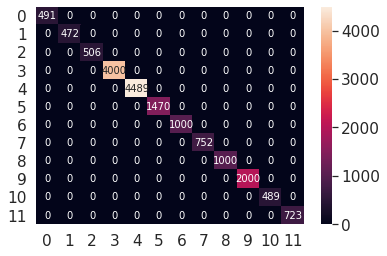


Accuracy 1.0


In [31]:
print_accuracy(test_labels.argmax(axis=1), test_pred.argmax(axis=1))

In [0]:
test_OOV_pred = model.predict(test_OOV_input)

matrix [[ 520    0    0    0    0    0    0    0    0    0    0    0]
 [   0  495    0    0    0    0    0    0    0    0    0    0]
 [   0    0  518    0    0    0    0    0    0    0    0    0]
 [   0    0    0 4000    0    0    0    0    0    0    0    0]
 [   0    0    0    0 4466    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1419    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0    0    0    0  742    0    0    0    0]
 [   0    0    0    0    0    0    0    0 1000    0    0    0]
 [   0    0    0    0    0    0    0    0    0 2000    0    0]
 [   0    0    0    0    0    0    0    0    0    0  501    0]
 [   0    0    0    0    0    0    0    0    0    0    0  748]]



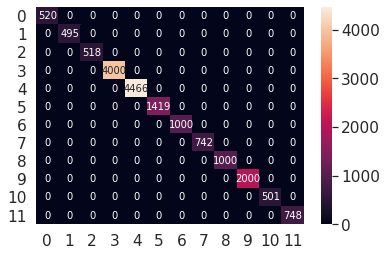


Accuracy 1.0


In [33]:
print_accuracy(test_OOV_labels.argmax(axis=1), test_OOV_pred.argmax(axis=1))

In [0]:
rev_answers =  {   0: 'where should it be',
                1: 'how many people would be in your party',
                2: 'which price range are looking for',
                3: 'api_call',
                4: 'sure is there anything else to update',
                5: 'sure let me find an other option for you',
                6: 'great let me do the reservation',
                7: 'phone_call',
                8: 'is there anything i can help you with',
                9: "you're welcome",
                10: 'any preference on a type of cuisine',
                11: '_address'}

In [0]:
test_labels_s = test_labels.argmax(axis=1)
test_pred_s = test_pred.argmax(axis=1)
for i in range(len(test_pred_s)):
  if test_labels_s[i] != test_pred_s[i]:
    print("input", task5_test["input"][i])
    print("input", task5_test["output"][i])
    print("test_labels_s[i]", test_labels_s[i], rev_answers[test_labels_s[i]])
    print("test_pred_s[i]", test_pred_s[i], rev_answers[test_pred_s[i]])
    print()